In [1]:
import add_to_syspath
import tensorflow as tf
import tensorflow.keras.backend as K
from lucid.modelzoo import audio_base
import lucid.optvis.objectives as objectives
import lucid.optvis.param as param
import lucid.optvis.render as render
import lucid.optvis.transform_audio as transform
from tqdm import tqdm
import numpy as np

In [2]:
model = audio_base.Model.load("../models/audionet2_lucid/frozen_graph_inference.pb")

In [3]:
transforms = [transform.jitter(1000), transform.pad(500, mode="constant", constant_value=0)]

In [4]:
writer = tf.summary.FileWriter("../tensorboard/lucid_optvis/")

In [43]:
obj = lambda T: T("dense3/BiasAdd")[0,0,0]

with tf.Graph().as_default() as graph, tf.Session() as sess:
    T = render.make_vis_T_grad(model, 
                          obj,
                          param_f=lambda : param.audio(8000), 
                          transforms=transforms, 
                          relu_gradient_override=True, 
                          optimizer=tf.train.AdamOptimizer(0.001)) 
    
    loss, grads, vis_op, t_audio = T("loss"), T("grads"), T("vis_op"), T("input")
    
    norm_gradient = tf.norm(grads[0][0])
    
    #for index, grad in enumerate(grads):
    #    tf.summary.histogram(f"optvis/{grad[1].name}", grad)
    
    #merged = tf.summary.merge_all()
    
    tf.global_variables_initializer().run()
    
    try:
        losses = []
        grads_list = []
        for i in tqdm(range(512)):
            loss_, _, n_grad = sess.run([loss, vis_op, norm_gradient])
            losses.append(loss_)
            grads_list.append(n_grad)
            #if i % 50: 
                #summary = merged.eval()
                #writer.add_summary(summary)
            
        vis = t_audio.eval()
        print(loss_)
        
    except KeyboardInterrupt:
        log.warning("Interrupted optimization at step {:d}.".format(i+1))
        vis = t_audio.eval()
        show(np.hstack(vis))

ValueError: Index out of range using input dim 2; input has only 2 dims for 'strided_slice_6' (op: 'StridedSlice') with input shapes: [1,10], [3], [3], [3] and with computed input tensors: input[3] = <1 1 1>.

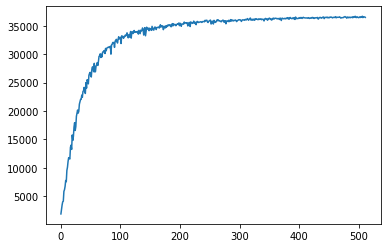

In [39]:
import matplotlib.pyplot as plts
plt.plot(losses)
print()

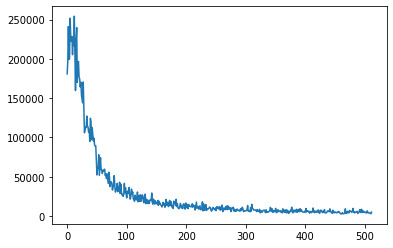

In [40]:
import matplotlib.pyplot as plt
plt.plot(grads_list)
print()

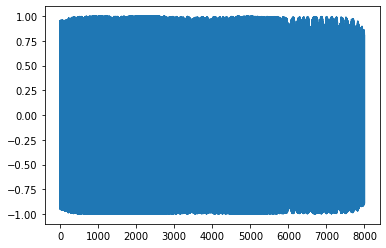

In [41]:
import matplotlib.pyplot as plt
plt.plot(vis[0,:,0])
from IPython.display import Audio
Audio(vis[0,:,0], rate=8000)

Frequency : 4000


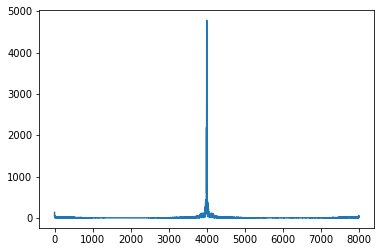

In [42]:
spect = np.abs(np.fft.fft(vis[0,:,0]))
plt.plot(spect)
print(f"Frequency : {np.argmax(spect)}")

In [6]:
model.show_graph()

In [44]:
model.image_value_range

[-1, 1]

In [ ]:
with tf.Ses